# Red Neuronal para Análisis de sentimientos
En el jupyter notebook se puede ver la construcción de un modelo SVM que predice el sentimiento de un comentario de redes sociales para dos productos ecuatorianos. Incluye la limpieza de datos, su preprocesamiento, preparación, construcción del modelo y evaluación del modelo.

In [13]:
import pandas as pd     #permite manipular datos
import numpy as np      #permite manipular números y matrices
import seaborn as sns   #permite manipulacion mediante graficos
sns.set_style("dark")   
import re               #proporciona coincidir con expresiones regulares
import string           #permite trabajos con formatos str
from string import punctuation
import nltk             #permite la utilzación de natural lenguaje toolkit
from nltk.corpus import stopwords  #bolsa de palabras stopwords
#nltk.download('stopwords')

from sklearn.ensemble import RandomForestClassifier   #clasificador
from sklearn.neighbors import KNeighborsClassifier    #clasificador
 
import matplotlib.pyplot as plt                               #librería de gráficos
from sklearn.model_selection import train_test_split         #permite entrenamiento de la data
from sklearn.feature_extraction.text import CountVectorizer  #convertir token a vector
from sklearn.feature_extraction.text import TfidfTransformer #utilizado para normalizar matrices 

import tensorflow as tf                                        #manejo con redes neuronales 
from tensorflow.keras.models import Sequential                 #manejo con redes neuronales 
from tensorflow.keras.layers import Dense, Activation, Dropout #manejo con redes neuronales 
from tensorflow.keras.callbacks import EarlyStopping           #manejo con redes neuronales 
import tensorflow.keras.metrics                                #manejo con redes neuronales 

from sklearn.model_selection import GridSearchCV               #optimizacion de hiperparámetros
#from keras.models import Sequential, Model                     #manejo con redes neuronales 
from keras.layers import Activation, Dense, Dropout            #manejo con redes neuronales 
from keras.wrappers.scikit_learn import KerasClassifier        #manejo con redes neuronales  

import pickle                                       #permite trabajo de datos como bytes
from sklearn.preprocessing import LabelBinarizer    #permite trabajar desde un cjto Y a matriz
import sklearn.datasets as skds                     #permite cargar archivos de texto
from pathlib import Path                            #permite trabajar con rutas concretas
import itertools                                    #permite crear iteradores para  bucles eficientes
from sklearn.metrics import confusion_matrix        #permite trabajar con matriz de confusión
# For reproducibility
np.random.seed(1237)                                #fija numeros aleatorios

In [14]:
pip install keras #biblioteca que permite la utilizacion de redes neuronales

Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: '#biblioteca'


In [15]:

data = pd.read_excel('TrainEcuadorFinal.xlsx')  #Cargar los datos
data.head()

,tweetid,user,content,value,country,Polarity_Rating
0,NaN,NaN,"""Mi comentario es Delilú porque así lo quieres...",NEU,Ecuador,Neutral
1,NaN,NaN,#Delilú #mi dulce delilú no podría comérmelo s...,P,Ecuador,Positive
2,NaN,NaN,#Delilù es la mejor crema de chocolate😋😋 ami f...,P,Ecuador,Positive
3,NaN,NaN,#DelilúEnNavidad Mi Árbolito Navideño✨🎄🎄 junto...,P,Ecuador,Positive
4,NaN,NaN,#DelilúEnNavidad MI ARBOLITO 🎄 NAVIDEÑO CON UN...,P,Ecuador,Positive


In [16]:
df2 = pd.DataFrame()
df2 = data
df2 = data.drop(['tweetid', 'user','value','country'], axis=1)
df2.dropna(inplace=True)
df2.head()

,content,Polarity_Rating
0,"""Mi comentario es Delilú porque así lo quieres...",Neutral
1,#Delilú #mi dulce delilú no podría comérmelo s...,Positive
2,#Delilù es la mejor crema de chocolate😋😋 ami f...,Positive
3,#DelilúEnNavidad Mi Árbolito Navideño✨🎄🎄 junto...,Positive
4,#DelilúEnNavidad MI ARBOLITO 🎄 NAVIDEÑO CON UN...,Positive


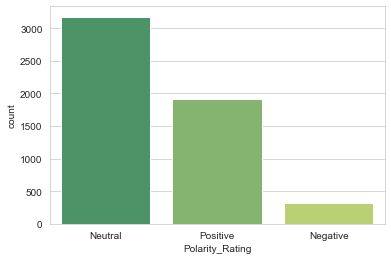

In [17]:
sns.set_style('whitegrid')
sns.countplot(x='Polarity_Rating',data=df2, palette='summer')

In [18]:
print(df2['Polarity_Rating'].value_counts())

Neutral     3178
Positive    1909
Negative     314
Name: Polarity_Rating, dtype: int64


#2 Preprocesamiento

In [19]:
df2['content'] = df2['content'].apply(lambda x: re.split('https:\/\/.*', str(x))[0]) #elimina url
df2['content'] = df2['content'].apply(lambda x: re.split('\d+', str(x))[0]) #elimina palabras con numeros

In [20]:
#elimina palabras con letras repetidas
def conti_rep_char(str1):
    tchr = str1.group(0)
    if len(tchr) > 1:
      return tchr[0:1]
      
def check_unique_char(rep, sent_text):
    
    convert = re.sub(r'(\w)\1+', rep,sent_text)
      
    #regresa la palabra convertida
    return convert
  
df2['content'] = df2['content'].apply(lambda x : check_unique_char(conti_rep_char,x))
df2

,content,Polarity_Rating
0,"""Mi comentario es Delilú porque así lo quieres...",Neutral
1,#Delilú #mi dulce delilú no podría comérmelo s...,Positive
2,#Delilù es la mejor crema de chocolate😋😋 ami f...,Positive
3,#DelilúEnNavidad Mi Árbolito Navideño✨🎄🎄 junto...,Positive
4,#DelilúEnNavidad MI ARBOLITO 🎄 NAVIDEÑO CON UN...,Positive
...,...,...
5396,#NuestraRecetaLaFavorita Nuestro sueño en fami...,Positive
5397,Uy que emoción desde hoy estaré muchísimo más ...,Positive
5398,¡Exquisita Rosa! Encuentra la receta aquí: bit...,Positive
5399,"Muy bien Wendy, nos encanta saber a quien admi...",Positive


In [21]:
import emoji 

def get_mentions_processing(text):
    return " ".join(filter(lambda x:x[0]!='@', text.split())) #no mentions

def get_hashtags_processing(text):
    return " ".join(filter(lambda x:x[0]!='#', text.split())) #no hashtags

def get_emojis_processing(text):
    return str(emoji.demojize(text,language='es')).replace(":"," ") #cambia emojis a texto

def get_less3words_processing(text):
    return ' '.join([word for word in text.split() if len(word)>2]) #elimina palabras con menos de 3 caracteres

def get_text_processing(text):
    stpword = stopwords.words('spanish')
    non_words = list(punctuation) #considera ¿ y ¡
    non_words.extend(['¿', '¡'])
    no_punctuation = [char for char in text if char not in non_words] #elimina puntuacion
    no_punctuation = ''.join(no_punctuation).lower() #convierte en minuscula
    return ' '.join([word for word in no_punctuation.split() if word.lower() not in stpword]) #elimina stopwords

def normalize(s): #elimina las vocales con tilde
    replacements = (
        ("á", "a"),
        ("é", "e"),
        ("í", "i"),
        ("ó", "o"),
        ("ú", "u"),
    )
    for a, b in replacements:
        s = s.replace(a, b).replace(a.upper(), b.upper())
    return s

In [22]:
df2 = df2.sample(frac=1).reset_index(drop=True)
df3 = pd.DataFrame()
df3 = df2
df3['content'] = df2['content']
df3['Content_Review'] = df2['content'].apply(get_mentions_processing)
df3['Content_Review1'] = df3['Content_Review'].apply(get_hashtags_processing)
df3['Content_Review2'] = df3['Content_Review1'].apply(get_emojis_processing)
df3['Content_Review3'] = df3['Content_Review2'].apply(get_text_processing)
df3['Content_Review4'] = df3['Content_Review3'].apply(get_less3words_processing)
df3['Content_Review5'] = df3['Content_Review4'].apply(normalize)
df3

,content,Polarity_Rating,Content_Review,Content_Review1,Content_Review2,Content_Review3,Content_Review4,Content_Review5
0,Mi #Delilu con @katysoledad.moyalopez 😂😂 @deli...,Positive,Mi #Delilu con 😂😂 un #DeliluAvelana 😁 me falta...,Mi con 😂😂 un 😁 me faltan x probar los demás 😎😋😋😋,Mi con cara_llorando_de_risa cara_llorando_d...,carallorandoderisa carallorandoderisa cararadi...,carallorandoderisa carallorandoderisa cararadi...,carallorandoderisa carallorandoderisa cararadi...
1,Caldo de bolas,Neutral,Caldo de bolas,Caldo de bolas,Caldo de bolas,caldo bolas,caldo bolas,caldo bolas
2,Riquisimo y el de bq tambien,Positive,Riquisimo y el de bq tambien,Riquisimo y el de bq tambien,Riquisimo y el de bq tambien,riquisimo bq tambien,riquisimo tambien,riquisimo tambien
3,#RecetaParaElExito del Sr. Luis Briones Los Ho...,Neutral,#RecetaParaElExito del Sr. Luis Briones Los Ho...,del Sr. Luis Briones Los Hot Dogs De La Gonzal...,del Sr. Luis Briones Los Hot Dogs De La Gonzal...,sr luis briones hot dogs gonzales suarez,luis briones hot dogs gonzales suarez,luis briones hot dogs gonzales suarez
4,Esta es una ensalada tipica k hago en mi casa ...,Positive,Esta es una ensalada tipica k hago en mi casa ...,Esta es una ensalada tipica k hago en mi casa ...,Esta es una ensalada tipica k hago en mi casa ...,ensalada tipica k hago casa salsa caesar chori...,ensalada tipica hago casa salsa caesar chorito...,ensalada tipica hago casa salsa caesar chorito...
...,...,...,...,...,...,...,...,...
5396,Wiliams Chila compreme😫,Neutral,Wiliams Chila compreme😫,Wiliams Chila compreme😫,Wiliams Chila compreme cara_cansada,wiliams chila compreme caracansada,wiliams chila compreme caracansada,wiliams chila compreme caracansada
5397,cuando van a poner la receta gracias x fa,Neutral,cuando van a poner la receta gracias x fa,cuando van a poner la receta gracias x fa,cuando van a poner la receta gracias x fa,van poner receta gracias x fa,van poner receta gracias,van poner receta gracias
5398,#elijodelilú porque es delicioso😍,Positive,#elijodelilú porque es delicioso😍,porque es delicioso😍,porque es delicioso cara_sonriendo_con_ojos_de...,delicioso carasonriendoconojosdecorazón,delicioso carasonriendoconojosdecorazón,delicioso carasonriendoconojosdecorazon
5399,Como cuando descubres que es mas saludable tom...,Positive,Como cuando descubres que es mas saludable tom...,Como cuando descubres que es mas saludable tom...,Como cuando descubres que es mas saludable tom...,descubres mas saludable tomarse heineken comer...,descubres mas saludable tomarse heineken comer...,descubres mas saludable tomarse heineken comer...


In [23]:
df4 = pd.DataFrame()
df4 = df3
df4 = df3[['Content_Review5', 'Polarity_Rating']]
print(df4.shape)
df4.head()

(5401, 2)


,Content_Review5,Polarity_Rating
0,carallorandoderisa carallorandoderisa cararadi...,Positive
1,caldo bolas,Neutral
2,riquisimo tambien,Positive
3,luis briones hot dogs gonzales suarez,Neutral
4,ensalada tipica hago casa salsa caesar chorito...,Positive


In [24]:
# Elimino registros con Answers NaN
df4['Content_Review5'].replace('', np.nan, inplace=True) # Reemplazo los registros vacíos con NaN
print(df4['Content_Review5'].isna().sum()) 
df4 = df4.dropna(axis=0, subset=['Content_Review5'])
print(df4.shape)
df4

317
(5084, 2)


C:\Users\gpulg\anaconda3\lib\site-packages\pandas\core\generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


,Content_Review5,Polarity_Rating
0,carallorandoderisa carallorandoderisa cararadi...,Positive
1,caldo bolas,Neutral
2,riquisimo tambien,Positive
3,luis briones hot dogs gonzales suarez,Neutral
4,ensalada tipica hago casa salsa caesar chorito...,Positive
...,...,...
5396,wiliams chila compreme caracansada,Neutral
5397,van poner receta gracias,Neutral
5398,delicioso carasonriendoconojosdecorazon,Positive
5399,descubres mas saludable tomarse heineken comer...,Positive


In [25]:
X=df4['Content_Review5'].values #se definen como valores
y=df4['Polarity_Rating'].values #se definen como valores

#Partición de la base entre testeo y entrenamiento

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, train_size=0.70, random_state=42)

In [26]:
print(X.shape)
print(y.shape)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(5084,)
(5084,)
(3558,)
(1526,)
(3558,)
(1526,)


In [27]:
y_test

array(['Positive', 'Neutral', 'Neutral', ..., 'Neutral', 'Neutral',
       'Positive'], dtype=object)

In [28]:
vect1 = CountVectorizer(min_df=2,ngram_range=(1,1)) #transformo los X (values) en vectores 
X_train = vect1.fit_transform(X_train) 
X_test = vect1.transform(X_test)

In [29]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3558, 2398)
(1526, 2398)
(3558,)
(1526,)


In [30]:
encoder = LabelBinarizer()  #Transformo los Y (values) en vectores
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)
y_train

array([[0, 1, 0],
       [0, 0, 1],
       [0, 1, 0],
       ...,
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 1]])

In [53]:
y_test

array([[0, 0, 1],
       [0, 1, 0],
       [0, 1, 0],
       ...,
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 1]])

In [31]:
train_size=int(len(df4) * .7)              #permite la visualización más adelante en la matriz de confusión
test_tags=df4['Polarity_Rating'][train_size:] #permite la visualización más adelante en la matriz de confusión

In [32]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3558, 2398)
(1526, 2398)
(3558, 3)
(1526, 3)


In [33]:
tfidf = TfidfTransformer(smooth_idf=True,use_idf=True) #Entrega ponderación de importancia a palabras más "importantes" (frecuentes)
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)
X_train = X_train.toarray()
X_test = X_test.toarray()

In [34]:
# print idf values 
df_idf = pd.DataFrame(tfidf.idf_, index=vect1.get_feature_names(),columns=["idf_weights"]) 
 
# sort ascending 
df_idf.sort_values(by=['idf_weights'])

,idf_weights
favorita,3.216230
gracias,3.521243
heineken,3.924961
mejor,4.127379
aceite,4.140282
...,...
iglesias,8.078623
ido,8.078623
iba,8.078623
increible,8.078623


In [35]:
y_train.shape

(3558, 3)

In [36]:
#4.1 red aplicada
from keras.constraints import maxnorm
from tensorflow import keras

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.CategoricalAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

model = Sequential()                                         #Se define estructura de la red capa por capa
model.add(Dense(units=1500, kernel_initializer='uniform', activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.9))
model.add(Dense(units=1200,kernel_initializer='uniform', activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.9))
model.add(Dense(units=3,kernel_initializer='zero', activation='softmax'))

#optimizer=tf.keras.optimizers.Adamax(0.001)
#model.compile(optimizer= 'adam' , loss= keras.losses.binary_crossentropy, metrics=['accuracy'])
model.compile(optimizer = 'adam',loss='categorical_crossentropy', metrics=METRICS)  #Se compila la red en conjunto a su optimizador


In [37]:
history = model.fit(X_train, y_train, batch_size=256, epochs=100, validation_split=0.3, verbose=1)

Epoch 1/100
10/10 [==============================] - 8s 374ms/step - loss: 1.0041 - tp: 168.0000 - fp: 109.0000 - tn: 4871.0000 - fn: 2322.0000 - accuracy: 0.5349 - precision: 0.6065 - recall: 0.0675 - auc: 0.7484 - prc: 0.5410 - val_loss: 0.9013 - val_tp: 580.0000 - val_fp: 463.0000 - val_tn: 1673.0000 - val_fn: 488.0000 - val_accuracy: 0.5581 - val_precision: 0.5561 - val_recall: 0.5431 - val_auc: 0.7583 - val_prc: 0.5753
Epoch 2/100
10/10 [==============================] - 1s 139ms/step - loss: 0.8554 - tp: 1454.0000 - fp: 1018.0000 - tn: 3962.0000 - fn: 1036.0000 - accuracy: 0.5892 - precision: 0.5882 - recall: 0.5839 - auc: 0.7779 - prc: 0.5869 - val_loss: 0.9045 - val_tp: 596.0000 - val_fp: 472.0000 - val_tn: 1664.0000 - val_fn: 472.0000 - val_accuracy: 0.5581 - val_precision: 0.5581 - val_recall: 0.5581 - val_auc: 0.8012 - val_prc: 0.6654
Epoch 3/100
10/10 [==============================] - 1s 144ms/step - loss: 0.8420 - tp: 1404.0000 - fp: 988.0000 - tn: 3992.0000 - fn: 1086.00

10/10 [==============================] - 1s 142ms/step - loss: 0.2808 - tp: 2143.0000 - fp: 196.0000 - tn: 4784.0000 - fn: 347.0000 - accuracy: 0.8819 - precision: 0.9162 - recall: 0.8606 - auc: 0.9787 - prc: 0.9624 - val_loss: 0.8100 - val_tp: 754.0000 - val_fp: 258.0000 - val_tn: 1878.0000 - val_fn: 314.0000 - val_accuracy: 0.7331 - val_precision: 0.7451 - val_recall: 0.7060 - val_auc: 0.8767 - val_prc: 0.7960
Epoch 21/100
10/10 [==============================] - 1s 138ms/step - loss: 0.2598 - tp: 2167.0000 - fp: 198.0000 - tn: 4782.0000 - fn: 323.0000 - accuracy: 0.8880 - precision: 0.9163 - recall: 0.8703 - auc: 0.9822 - prc: 0.9690 - val_loss: 0.8376 - val_tp: 750.0000 - val_fp: 258.0000 - val_tn: 1878.0000 - val_fn: 318.0000 - val_accuracy: 0.7285 - val_precision: 0.7440 - val_recall: 0.7022 - val_auc: 0.8749 - val_prc: 0.7949
Epoch 22/100
10/10 [==============================] - 1s 141ms/step - loss: 0.2564 - tp: 2173.0000 - fp: 180.0000 - tn: 4800.0000 - fn: 317.0000 - accuracy

10/10 [==============================] - 1s 141ms/step - loss: 0.1320 - tp: 2320.0000 - fp: 83.0000 - tn: 4897.0000 - fn: 170.0000 - accuracy: 0.9522 - precision: 0.9655 - recall: 0.9317 - auc: 0.9953 - prc: 0.9910 - val_loss: 1.2294 - val_tp: 761.0000 - val_fp: 295.0000 - val_tn: 1841.0000 - val_fn: 307.0000 - val_accuracy: 0.7191 - val_precision: 0.7206 - val_recall: 0.7125 - val_auc: 0.8589 - val_prc: 0.7568
Epoch 40/100
10/10 [==============================] - 1s 135ms/step - loss: 0.1370 - tp: 2318.0000 - fp: 86.0000 - tn: 4894.0000 - fn: 172.0000 - accuracy: 0.9526 - precision: 0.9642 - recall: 0.9309 - auc: 0.9949 - prc: 0.9905 - val_loss: 1.2253 - val_tp: 758.0000 - val_fp: 294.0000 - val_tn: 1842.0000 - val_fn: 310.0000 - val_accuracy: 0.7154 - val_precision: 0.7205 - val_recall: 0.7097 - val_auc: 0.8581 - val_prc: 0.7534
Epoch 41/100
10/10 [==============================] - 1s 143ms/step - loss: 0.1242 - tp: 2342.0000 - fp: 76.0000 - tn: 4904.0000 - fn: 148.0000 - accuracy: 0

10/10 [==============================] - 1s 133ms/step - loss: 0.0875 - tp: 2421.0000 - fp: 57.0000 - tn: 4923.0000 - fn: 69.0000 - accuracy: 0.9751 - precision: 0.9770 - recall: 0.9723 - auc: 0.9967 - prc: 0.9938 - val_loss: 1.4727 - val_tp: 761.0000 - val_fp: 296.0000 - val_tn: 1840.0000 - val_fn: 307.0000 - val_accuracy: 0.7154 - val_precision: 0.7200 - val_recall: 0.7125 - val_auc: 0.8537 - val_prc: 0.7379
Epoch 59/100
10/10 [==============================] - 1s 141ms/step - loss: 0.0842 - tp: 2414.0000 - fp: 65.0000 - tn: 4915.0000 - fn: 76.0000 - accuracy: 0.9727 - precision: 0.9738 - recall: 0.9695 - auc: 0.9974 - prc: 0.9950 - val_loss: 1.4983 - val_tp: 760.0000 - val_fp: 298.0000 - val_tn: 1838.0000 - val_fn: 308.0000 - val_accuracy: 0.7154 - val_precision: 0.7183 - val_recall: 0.7116 - val_auc: 0.8519 - val_prc: 0.7343
Epoch 60/100
10/10 [==============================] - 1s 144ms/step - loss: 0.0871 - tp: 2410.0000 - fp: 62.0000 - tn: 4918.0000 - fn: 80.0000 - accuracy: 0.97

10/10 [==============================] - 1s 139ms/step - loss: 0.0801 - tp: 2413.0000 - fp: 67.0000 - tn: 4913.0000 - fn: 77.0000 - accuracy: 0.9703 - precision: 0.9730 - recall: 0.9691 - auc: 0.9976 - prc: 0.9954 - val_loss: 1.5965 - val_tp: 756.0000 - val_fp: 303.0000 - val_tn: 1833.0000 - val_fn: 312.0000 - val_accuracy: 0.7097 - val_precision: 0.7139 - val_recall: 0.7079 - val_auc: 0.8511 - val_prc: 0.7340
Epoch 78/100
10/10 [==============================] - 1s 135ms/step - loss: 0.0797 - tp: 2425.0000 - fp: 57.0000 - tn: 4923.0000 - fn: 65.0000 - accuracy: 0.9751 - precision: 0.9770 - recall: 0.9739 - auc: 0.9969 - prc: 0.9943 - val_loss: 1.6159 - val_tp: 761.0000 - val_fp: 302.0000 - val_tn: 1834.0000 - val_fn: 307.0000 - val_accuracy: 0.7135 - val_precision: 0.7159 - val_recall: 0.7125 - val_auc: 0.8517 - val_prc: 0.7361
Epoch 79/100
10/10 [==============================] - 1s 143ms/step - loss: 0.0700 - tp: 2429.0000 - fp: 56.0000 - tn: 4924.0000 - fn: 61.0000 - accuracy: 0.97

10/10 [==============================] - 2s 141ms/step - loss: 0.0636 - tp: 2436.0000 - fp: 47.0000 - tn: 4933.0000 - fn: 54.0000 - accuracy: 0.9799 - precision: 0.9811 - recall: 0.9783 - auc: 0.9985 - prc: 0.9975 - val_loss: 1.6745 - val_tp: 755.0000 - val_fp: 308.0000 - val_tn: 1828.0000 - val_fn: 313.0000 - val_accuracy: 0.7079 - val_precision: 0.7103 - val_recall: 0.7069 - val_auc: 0.8485 - val_prc: 0.7304
Epoch 97/100
10/10 [==============================] - 4s 485ms/step - loss: 0.0584 - tp: 2435.0000 - fp: 48.0000 - tn: 4932.0000 - fn: 55.0000 - accuracy: 0.9803 - precision: 0.9807 - recall: 0.9779 - auc: 0.9990 - prc: 0.9981 - val_loss: 1.6626 - val_tp: 758.0000 - val_fp: 306.0000 - val_tn: 1830.0000 - val_fn: 310.0000 - val_accuracy: 0.7107 - val_precision: 0.7124 - val_recall: 0.7097 - val_auc: 0.8490 - val_prc: 0.7307
Epoch 98/100
10/10 [==============================] - 3s 206ms/step - loss: 0.0688 - tp: 2425.0000 - fp: 57.0000 - tn: 4923.0000 - fn: 65.0000 - accuracy: 0.97

In [38]:
score = model.evaluate(X_test, y_test, batch_size=64, verbose=1)  #Evaluar el modelo.

#print('Test accuracy:', score[1])

24/24 [==============================] - 0s 14ms/step - loss: 1.4184 - tp: 1146.0000 - fp: 374.0000 - tn: 2678.0000 - fn: 380.0000 - accuracy: 0.7523 - precision: 0.7539 - recall: 0.7510 - auc: 0.8739 - prc: 0.7733


In [28]:
X_train.shape

(3558, 2398)

In [76]:
#OPTIMIZER ALGORITHM
# Use scikit-learn to grid search the batch size and epochs
import numpy
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
# Function to create model, required for KerasClassifier
def create_model(optimizer='adam'):
	# create model
	model = Sequential()
	model.add(Dense(12, input_dim=2398, activation='relu'))
	model.add(Dense(3, activation='hard_sigmoid'))
	# Compile model
	model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
	return model
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)
# load dataset
Xx = X_train
Yy = y_train
# create model
model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=10, verbose=0)
# define the grid search parameters
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(optimizer=optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(Xx, Yy)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.724283 using {'optimizer': 'Adamax'}
0.721192 (0.009090) with: {'optimizer': 'SGD'}
0.724002 (0.001733) with: {'optimizer': 'RMSprop'}
0.579820 (0.011465) with: {'optimizer': 'Adagrad'}
0.570264 (0.021610) with: {'optimizer': 'Adadelta'}
0.671726 (0.012341) with: {'optimizer': 'Adam'}
0.724283 (0.004819) with: {'optimizer': 'Adamax'}
0.669477 (0.007188) with: {'optimizer': 'Nadam'}


In [79]:
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import schedules

In [81]:
# Use scikit-learn to grid search the activation function
import numpy
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
# Function to create model, required for KerasClassifier
def create_model(activation='relu'):
	# create model
	model = Sequential()
	model.add(Dense(12, input_dim=2398, kernel_initializer='uniform', activation=activation))
	model.add(Dense(3, kernel_initializer='uniform', activation='sigmoid'))
	# Compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)
# load dataset
Xx = X_train
Yy = y_train
# create model
model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=10, verbose=0)
# define the grid search parameters
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
param_grid = dict(activation=activation)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(Xx, Yy)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


Best: 0.703766 using {'activation': 'hard_sigmoid'}
0.699831 (0.006310) with: {'activation': 'softmax'}
0.682406 (0.006397) with: {'activation': 'softplus'}
0.667229 (0.007297) with: {'activation': 'softsign'}
0.675379 (0.003577) with: {'activation': 'relu'}
0.661046 (0.008789) with: {'activation': 'tanh'}
0.694210 (0.005167) with: {'activation': 'sigmoid'}
0.703766 (0.006757) with: {'activation': 'hard_sigmoid'}
0.663575 (0.005377) with: {'activation': 'linear'}


In [39]:
from keras.constraints import maxnorm
from tensorflow import keras

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.CategoricalAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

model = Sequential()
model.add(Dense(units=1500, kernel_initializer='uniform', activation='hard_sigmoid', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Dense(units=1200,kernel_initializer='uniform', activation='hard_sigmoid', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Dense(units=3,kernel_initializer='zero', activation='softmax'))

#optimizer=tf.keras.optimizers.Adamax(0.001)
#model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=METRICS)
model.compile(optimizer = 'Adamax',loss='categorical_crossentropy', metrics=METRICS)

In [40]:
history = model.fit(X_train, y_train, batch_size=256, epochs=100, validation_split=0.2, verbose=1)

Epoch 1/100
12/12 [==============================] - 12s 325ms/step - loss: 0.8931 - tp: 1515.0000 - fp: 1075.0000 - tn: 4617.0000 - fn: 1331.0000 - accuracy: 0.5369 - precision: 0.5849 - recall: 0.5323 - auc: 0.7473 - prc: 0.5345 - val_loss: 0.8954 - val_tp: 389.0000 - val_fp: 323.0000 - val_tn: 1101.0000 - val_fn: 323.0000 - val_accuracy: 0.5463 - val_precision: 0.5463 - val_recall: 0.5463 - val_auc: 0.7410 - val_prc: 0.5194
Epoch 2/100
12/12 [==============================] - 2s 140ms/step - loss: 0.8480 - tp: 1674.0000 - fp: 1172.0000 - tn: 4520.0000 - fn: 1172.0000 - accuracy: 0.5882 - precision: 0.5882 - recall: 0.5882 - auc: 0.7674 - prc: 0.5574 - val_loss: 0.9032 - val_tp: 389.0000 - val_fp: 323.0000 - val_tn: 1101.0000 - val_fn: 323.0000 - val_accuracy: 0.5463 - val_precision: 0.5463 - val_recall: 0.5463 - val_auc: 0.7353 - val_prc: 0.5149
Epoch 3/100
12/12 [==============================] - 2s 138ms/step - loss: 0.8467 - tp: 1674.0000 - fp: 1172.0000 - tn: 4520.0000 - fn: 117

12/12 [==============================] - 6s 507ms/step - loss: 0.8378 - tp: 1674.0000 - fp: 1172.0000 - tn: 4520.0000 - fn: 1172.0000 - accuracy: 0.5882 - precision: 0.5882 - recall: 0.5882 - auc: 0.8115 - prc: 0.6697 - val_loss: 0.8907 - val_tp: 389.0000 - val_fp: 323.0000 - val_tn: 1101.0000 - val_fn: 323.0000 - val_accuracy: 0.5463 - val_precision: 0.5463 - val_recall: 0.5463 - val_auc: 0.8184 - val_prc: 0.7149
Epoch 21/100
12/12 [==============================] - 3s 235ms/step - loss: 0.8360 - tp: 1674.0000 - fp: 1172.0000 - tn: 4520.0000 - fn: 1172.0000 - accuracy: 0.5882 - precision: 0.5882 - recall: 0.5882 - auc: 0.7939 - prc: 0.6289 - val_loss: 0.8831 - val_tp: 389.0000 - val_fp: 323.0000 - val_tn: 1101.0000 - val_fn: 323.0000 - val_accuracy: 0.5463 - val_precision: 0.5463 - val_recall: 0.5463 - val_auc: 0.8176 - val_prc: 0.7163
Epoch 22/100
12/12 [==============================] - 5s 350ms/step - loss: 0.8349 - tp: 1674.0000 - fp: 1169.0000 - tn: 4523.0000 - fn: 1172.0000 - ac

12/12 [==============================] - 5s 432ms/step - loss: 0.6703 - tp: 1946.0000 - fp: 621.0000 - tn: 5071.0000 - fn: 900.0000 - accuracy: 0.7280 - precision: 0.7581 - recall: 0.6838 - auc: 0.8850 - prc: 0.8166 - val_loss: 0.7464 - val_tp: 454.0000 - val_fp: 209.0000 - val_tn: 1215.0000 - val_fn: 258.0000 - val_accuracy: 0.6756 - val_precision: 0.6848 - val_recall: 0.6376 - val_auc: 0.8474 - val_prc: 0.7572
Epoch 40/100
12/12 [==============================] - 2s 144ms/step - loss: 0.6561 - tp: 2003.0000 - fp: 597.0000 - tn: 5095.0000 - fn: 843.0000 - accuracy: 0.7446 - precision: 0.7704 - recall: 0.7038 - auc: 0.8910 - prc: 0.8208 - val_loss: 0.7397 - val_tp: 450.0000 - val_fp: 143.0000 - val_tn: 1281.0000 - val_fn: 262.0000 - val_accuracy: 0.7008 - val_precision: 0.7589 - val_recall: 0.6320 - val_auc: 0.8618 - val_prc: 0.7759
Epoch 41/100
12/12 [==============================] - 6s 505ms/step - loss: 0.6471 - tp: 2038.0000 - fp: 556.0000 - tn: 5136.0000 - fn: 808.0000 - accuracy

12/12 [==============================] - 2s 135ms/step - loss: 0.5468 - tp: 2153.0000 - fp: 507.0000 - tn: 5185.0000 - fn: 693.0000 - accuracy: 0.7885 - precision: 0.8094 - recall: 0.7565 - auc: 0.9225 - prc: 0.8763 - val_loss: 0.6670 - val_tp: 502.0000 - val_fp: 172.0000 - val_tn: 1252.0000 - val_fn: 210.0000 - val_accuracy: 0.7275 - val_precision: 0.7448 - val_recall: 0.7051 - val_auc: 0.8832 - val_prc: 0.8083
Epoch 59/100
12/12 [==============================] - 2s 131ms/step - loss: 0.5334 - tp: 2198.0000 - fp: 498.0000 - tn: 5194.0000 - fn: 648.0000 - accuracy: 0.7973 - precision: 0.8153 - recall: 0.7723 - auc: 0.9261 - prc: 0.8829 - val_loss: 0.6547 - val_tp: 508.0000 - val_fp: 170.0000 - val_tn: 1254.0000 - val_fn: 204.0000 - val_accuracy: 0.7331 - val_precision: 0.7493 - val_recall: 0.7135 - val_auc: 0.8874 - val_prc: 0.8167
Epoch 60/100
12/12 [==============================] - 2s 134ms/step - loss: 0.5291 - tp: 2208.0000 - fp: 501.0000 - tn: 5191.0000 - fn: 638.0000 - accuracy

12/12 [==============================] - 2s 137ms/step - loss: 0.4934 - tp: 2262.0000 - fp: 444.0000 - tn: 5248.0000 - fn: 584.0000 - accuracy: 0.8148 - precision: 0.8359 - recall: 0.7948 - auc: 0.9365 - prc: 0.8988 - val_loss: 0.6745 - val_tp: 511.0000 - val_fp: 171.0000 - val_tn: 1253.0000 - val_fn: 201.0000 - val_accuracy: 0.7275 - val_precision: 0.7493 - val_recall: 0.7177 - val_auc: 0.8855 - val_prc: 0.8114
Epoch 78/100
12/12 [==============================] - 2s 142ms/step - loss: 0.4893 - tp: 2269.0000 - fp: 433.0000 - tn: 5259.0000 - fn: 577.0000 - accuracy: 0.8180 - precision: 0.8397 - recall: 0.7973 - auc: 0.9377 - prc: 0.9005 - val_loss: 0.6932 - val_tp: 503.0000 - val_fp: 175.0000 - val_tn: 1249.0000 - val_fn: 209.0000 - val_accuracy: 0.7346 - val_precision: 0.7419 - val_recall: 0.7065 - val_auc: 0.8800 - val_prc: 0.8041
Epoch 79/100
12/12 [==============================] - 2s 141ms/step - loss: 0.5167 - tp: 2223.0000 - fp: 491.0000 - tn: 5201.0000 - fn: 623.0000 - accuracy

Epoch 96/100
12/12 [==============================] - 2s 187ms/step - loss: 0.4805 - tp: 2280.0000 - fp: 431.0000 - tn: 5261.0000 - fn: 566.0000 - accuracy: 0.8222 - precision: 0.8410 - recall: 0.8011 - auc: 0.9397 - prc: 0.9038 - val_loss: 0.6779 - val_tp: 508.0000 - val_fp: 161.0000 - val_tn: 1263.0000 - val_fn: 204.0000 - val_accuracy: 0.7486 - val_precision: 0.7593 - val_recall: 0.7135 - val_auc: 0.8822 - val_prc: 0.8087
Epoch 97/100
12/12 [==============================] - 2s 185ms/step - loss: 0.4700 - tp: 2302.0000 - fp: 422.0000 - tn: 5270.0000 - fn: 544.0000 - accuracy: 0.8257 - precision: 0.8451 - recall: 0.8089 - auc: 0.9424 - prc: 0.9086 - val_loss: 0.6809 - val_tp: 515.0000 - val_fp: 167.0000 - val_tn: 1257.0000 - val_fn: 197.0000 - val_accuracy: 0.7416 - val_precision: 0.7551 - val_recall: 0.7233 - val_auc: 0.8836 - val_prc: 0.8104
Epoch 98/100
12/12 [==============================] - 2s 186ms/step - loss: 0.4800 - tp: 2254.0000 - fp: 459.0000 - tn: 5233.0000 - fn: 592.00

In [41]:
score = model.evaluate(X_test, y_test, batch_size=64, verbose=1)

#print('Test accuracy:', score[1])

24/24 [==============================] - 1s 20ms/step - loss: 0.6204 - tp: 1124.0000 - fp: 306.0000 - tn: 2746.0000 - fn: 402.0000 - accuracy: 0.7628 - precision: 0.7860 - recall: 0.7366 - auc: 0.8978 - prc: 0.8338


In [42]:
prediction = model.predict(X_test)

In [43]:
predictions = np.argmax(prediction, axis = 1)

In [44]:
predictions

array([2, 1, 1, ..., 1, 1, 1], dtype=int64)

In [45]:
y_test_labels = np.argmax(y_test, axis =1)

In [46]:
y_test_labels

array([2, 1, 1, ..., 1, 1, 2], dtype=int64)

In [47]:
y_train_labels = np.argmax(y_train, axis =1)
y_train_labels

array([1, 2, 1, ..., 1, 1, 2], dtype=int64)

In [48]:

from sklearn.utils import class_weight   #Estima los pesos de las clases
weight = class_weight.compute_class_weight('balanced', np.unique(y_train_labels), y_train_labels)
weight = {i : weight[i] for i in range(3)}
weight

C:\Users\gpulg\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[1 2 1 ... 1 1 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 5.390909090909091, 1: 0.5748909355307804, 2: 0.9301960784313725}

In [49]:
num_epochs =200
batch_size = 256
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=num_epochs,
                    verbose=2,
                    class_weight=weight,   #con el class_weight le digo al modelo q tenga especial atencion con la clase sobre/infra representada 
                    validation_split=0.2)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/200
12/12 - 6s - loss: 0.8545 - tp: 2100.0000 - fp: 297.0000 - tn: 5395.0000 - fn: 746.0000 - accuracy: 0.8173 - precision: 0.8761 - recall: 0.7379 - auc: 0.9293 - prc: 0.8919 - val_loss: 0.8494 - val_tp: 352.0000 - val_fp: 58.0000 - val_tn: 1366.0000 - val_fn: 360.0000 - val_accuracy: 0.6489 - val_precision: 0.8585 - val_recall: 0.4944 - val_auc: 0.8085 - val_prc: 0.7490
Epoch 2/200
12/12 - 2s - loss: 0.7643 - tp: 1586.0000 - fp: 103.0000 - tn: 5589.0000 - fn: 1260.0000 - accuracy: 0.6750 - precision: 0.9390 - recall: 0.5573 - auc: 0.8579 - prc: 0.8145 - val_loss: 0.8466 - val_tp: 370.0000 - val_fp: 63.0000 - val_tn: 1361.0000 - val_fn: 342.0000 - val_accuracy: 0.6461 - val_precision: 0.8545 - val_recall: 0.5197 - val_auc: 0.8107 - val_prc: 0.7482
Epoch 3/200
12/12 - 2s - loss: 0.7420 - tp: 1855.0000 - fp: 172.0000 - tn: 5520.0000 - fn: 991.

Epoch 22/200
12/12 - 2s - loss: 0.6952 - tp: 1910.0000 - fp: 194.0000 - tn: 5498.0000 - fn: 936.0000 - accuracy: 0.7365 - precision: 0.9078 - recall: 0.6711 - auc: 0.8995 - prc: 0.8640 - val_loss: 0.8499 - val_tp: 433.0000 - val_fp: 103.0000 - val_tn: 1321.0000 - val_fn: 279.0000 - val_accuracy: 0.6770 - val_precision: 0.8078 - val_recall: 0.6081 - val_auc: 0.8304 - val_prc: 0.7667
Epoch 23/200
12/12 - 2s - loss: 0.7010 - tp: 1919.0000 - fp: 199.0000 - tn: 5493.0000 - fn: 927.0000 - accuracy: 0.7519 - precision: 0.9060 - recall: 0.6743 - auc: 0.9012 - prc: 0.8671 - val_loss: 0.9440 - val_tp: 380.0000 - val_fp: 187.0000 - val_tn: 1237.0000 - val_fn: 332.0000 - val_accuracy: 0.5927 - val_precision: 0.6702 - val_recall: 0.5337 - val_auc: 0.7809 - val_prc: 0.7094
Epoch 24/200
12/12 - 2s - loss: 0.7006 - tp: 1880.0000 - fp: 204.0000 - tn: 5488.0000 - fn: 966.0000 - accuracy: 0.7316 - precision: 0.9021 - recall: 0.6606 - auc: 0.8917 - prc: 0.8550 - val_loss: 0.8784 - val_tp: 393.0000 - val_f

Epoch 44/200
12/12 - 2s - loss: 0.6948 - tp: 1822.0000 - fp: 725.0000 - tn: 4967.0000 - fn: 1024.0000 - accuracy: 0.6785 - precision: 0.7154 - recall: 0.6402 - auc: 0.8669 - prc: 0.8151 - val_loss: 0.8836 - val_tp: 404.0000 - val_fp: 88.0000 - val_tn: 1336.0000 - val_fn: 308.0000 - val_accuracy: 0.6615 - val_precision: 0.8211 - val_recall: 0.5674 - val_auc: 0.8213 - val_prc: 0.7540
Epoch 45/200
12/12 - 2s - loss: 0.6687 - tp: 1982.0000 - fp: 285.0000 - tn: 5407.0000 - fn: 864.0000 - accuracy: 0.7544 - precision: 0.8743 - recall: 0.6964 - auc: 0.9086 - prc: 0.8732 - val_loss: 0.9628 - val_tp: 389.0000 - val_fp: 217.0000 - val_tn: 1207.0000 - val_fn: 323.0000 - val_accuracy: 0.5871 - val_precision: 0.6419 - val_recall: 0.5463 - val_auc: 0.7902 - val_prc: 0.7156
Epoch 46/200
12/12 - 6s - loss: 0.6794 - tp: 1937.0000 - fp: 462.0000 - tn: 5230.0000 - fn: 909.0000 - accuracy: 0.7256 - precision: 0.8074 - recall: 0.6806 - auc: 0.8959 - prc: 0.8592 - val_loss: 1.0125 - val_tp: 385.0000 - val_f

Epoch 66/200
12/12 - 2s - loss: 0.6662 - tp: 1996.0000 - fp: 319.0000 - tn: 5373.0000 - fn: 850.0000 - accuracy: 0.7579 - precision: 0.8622 - recall: 0.7013 - auc: 0.9092 - prc: 0.8734 - val_loss: 0.9501 - val_tp: 404.0000 - val_fp: 249.0000 - val_tn: 1175.0000 - val_fn: 308.0000 - val_accuracy: 0.5829 - val_precision: 0.6187 - val_recall: 0.5674 - val_auc: 0.7887 - val_prc: 0.7151
Epoch 67/200
12/12 - 2s - loss: 0.6298 - tp: 1990.0000 - fp: 402.0000 - tn: 5290.0000 - fn: 856.0000 - accuracy: 0.7396 - precision: 0.8319 - recall: 0.6992 - auc: 0.9064 - prc: 0.8694 - val_loss: 0.9070 - val_tp: 398.0000 - val_fp: 104.0000 - val_tn: 1320.0000 - val_fn: 314.0000 - val_accuracy: 0.6222 - val_precision: 0.7928 - val_recall: 0.5590 - val_auc: 0.8111 - val_prc: 0.7406
Epoch 68/200
12/12 - 2s - loss: 0.6540 - tp: 2021.0000 - fp: 269.0000 - tn: 5423.0000 - fn: 825.0000 - accuracy: 0.7748 - precision: 0.8825 - recall: 0.7101 - auc: 0.9184 - prc: 0.8859 - val_loss: 1.0078 - val_tp: 390.0000 - val_f

Epoch 88/200
12/12 - 6s - loss: 0.6315 - tp: 1982.0000 - fp: 513.0000 - tn: 5179.0000 - fn: 864.0000 - accuracy: 0.7424 - precision: 0.7944 - recall: 0.6964 - auc: 0.9048 - prc: 0.8630 - val_loss: 0.9158 - val_tp: 416.0000 - val_fp: 149.0000 - val_tn: 1275.0000 - val_fn: 296.0000 - val_accuracy: 0.6362 - val_precision: 0.7363 - val_recall: 0.5843 - val_auc: 0.8165 - val_prc: 0.7479
Epoch 89/200
12/12 - 2s - loss: 0.6317 - tp: 1951.0000 - fp: 582.0000 - tn: 5110.0000 - fn: 895.0000 - accuracy: 0.7182 - precision: 0.7702 - recall: 0.6855 - auc: 0.8940 - prc: 0.8514 - val_loss: 0.8616 - val_tp: 449.0000 - val_fp: 120.0000 - val_tn: 1304.0000 - val_fn: 263.0000 - val_accuracy: 0.6924 - val_precision: 0.7891 - val_recall: 0.6306 - val_auc: 0.8393 - val_prc: 0.7735
Epoch 90/200
12/12 - 2s - loss: 0.6319 - tp: 2017.0000 - fp: 470.0000 - tn: 5222.0000 - fn: 829.0000 - accuracy: 0.7516 - precision: 0.8110 - recall: 0.7087 - auc: 0.9081 - prc: 0.8691 - val_loss: 0.9272 - val_tp: 410.0000 - val_f

Epoch 110/200
12/12 - 2s - loss: 0.5786 - tp: 2014.0000 - fp: 554.0000 - tn: 5138.0000 - fn: 832.0000 - accuracy: 0.7431 - precision: 0.7843 - recall: 0.7077 - auc: 0.9038 - prc: 0.8595 - val_loss: 0.8501 - val_tp: 434.0000 - val_fp: 120.0000 - val_tn: 1304.0000 - val_fn: 278.0000 - val_accuracy: 0.7121 - val_precision: 0.7834 - val_recall: 0.6096 - val_auc: 0.8436 - val_prc: 0.7777
Epoch 111/200
12/12 - 2s - loss: 0.6109 - tp: 2009.0000 - fp: 491.0000 - tn: 5201.0000 - fn: 837.0000 - accuracy: 0.7470 - precision: 0.8036 - recall: 0.7059 - auc: 0.9070 - prc: 0.8666 - val_loss: 0.9128 - val_tp: 414.0000 - val_fp: 117.0000 - val_tn: 1307.0000 - val_fn: 298.0000 - val_accuracy: 0.6433 - val_precision: 0.7797 - val_recall: 0.5815 - val_auc: 0.8155 - val_prc: 0.7457
Epoch 112/200
12/12 - 2s - loss: 0.6155 - tp: 2122.0000 - fp: 373.0000 - tn: 5319.0000 - fn: 724.0000 - accuracy: 0.7980 - precision: 0.8505 - recall: 0.7456 - auc: 0.9265 - prc: 0.8928 - val_loss: 1.1972 - val_tp: 325.0000 - va

Epoch 132/200
12/12 - 2s - loss: 0.5626 - tp: 2089.0000 - fp: 397.0000 - tn: 5295.0000 - fn: 757.0000 - accuracy: 0.7857 - precision: 0.8403 - recall: 0.7340 - auc: 0.9227 - prc: 0.8870 - val_loss: 0.9640 - val_tp: 412.0000 - val_fp: 231.0000 - val_tn: 1193.0000 - val_fn: 300.0000 - val_accuracy: 0.6110 - val_precision: 0.6407 - val_recall: 0.5787 - val_auc: 0.8000 - val_prc: 0.7277
Epoch 133/200
12/12 - 2s - loss: 0.5588 - tp: 2113.0000 - fp: 416.0000 - tn: 5276.0000 - fn: 733.0000 - accuracy: 0.7807 - precision: 0.8355 - recall: 0.7424 - auc: 0.9237 - prc: 0.8892 - val_loss: 0.9073 - val_tp: 422.0000 - val_fp: 152.0000 - val_tn: 1272.0000 - val_fn: 290.0000 - val_accuracy: 0.6362 - val_precision: 0.7352 - val_recall: 0.5927 - val_auc: 0.8208 - val_prc: 0.7526
Epoch 134/200
12/12 - 2s - loss: 0.5493 - tp: 2113.0000 - fp: 398.0000 - tn: 5294.0000 - fn: 733.0000 - accuracy: 0.7839 - precision: 0.8415 - recall: 0.7424 - auc: 0.9270 - prc: 0.8939 - val_loss: 0.9042 - val_tp: 426.0000 - va

Epoch 154/200
12/12 - 2s - loss: 0.5137 - tp: 2145.0000 - fp: 405.0000 - tn: 5287.0000 - fn: 701.0000 - accuracy: 0.7973 - precision: 0.8412 - recall: 0.7537 - auc: 0.9313 - prc: 0.8954 - val_loss: 0.8141 - val_tp: 466.0000 - val_fp: 137.0000 - val_tn: 1287.0000 - val_fn: 246.0000 - val_accuracy: 0.7163 - val_precision: 0.7728 - val_recall: 0.6545 - val_auc: 0.8552 - val_prc: 0.7876
Epoch 155/200
12/12 - 2s - loss: 0.5237 - tp: 2165.0000 - fp: 396.0000 - tn: 5296.0000 - fn: 681.0000 - accuracy: 0.7944 - precision: 0.8454 - recall: 0.7607 - auc: 0.9311 - prc: 0.8961 - val_loss: 0.8804 - val_tp: 433.0000 - val_fp: 171.0000 - val_tn: 1253.0000 - val_fn: 279.0000 - val_accuracy: 0.6517 - val_precision: 0.7169 - val_recall: 0.6081 - val_auc: 0.8286 - val_prc: 0.7589
Epoch 156/200
12/12 - 2s - loss: 0.5285 - tp: 2154.0000 - fp: 424.0000 - tn: 5268.0000 - fn: 692.0000 - accuracy: 0.7923 - precision: 0.8355 - recall: 0.7569 - auc: 0.9270 - prc: 0.8895 - val_loss: 0.8637 - val_tp: 433.0000 - va

Epoch 176/200
12/12 - 2s - loss: 0.5241 - tp: 2180.0000 - fp: 451.0000 - tn: 5241.0000 - fn: 666.0000 - accuracy: 0.7959 - precision: 0.8286 - recall: 0.7660 - auc: 0.9277 - prc: 0.8869 - val_loss: 0.7973 - val_tp: 451.0000 - val_fp: 136.0000 - val_tn: 1288.0000 - val_fn: 261.0000 - val_accuracy: 0.7205 - val_precision: 0.7683 - val_recall: 0.6334 - val_auc: 0.8551 - val_prc: 0.7833
Epoch 177/200
12/12 - 2s - loss: 0.5086 - tp: 2160.0000 - fp: 422.0000 - tn: 5270.0000 - fn: 686.0000 - accuracy: 0.7955 - precision: 0.8366 - recall: 0.7590 - auc: 0.9376 - prc: 0.9011 - val_loss: 0.8039 - val_tp: 457.0000 - val_fp: 136.0000 - val_tn: 1288.0000 - val_fn: 255.0000 - val_accuracy: 0.7051 - val_precision: 0.7707 - val_recall: 0.6419 - val_auc: 0.8544 - val_prc: 0.7840
Epoch 178/200
12/12 - 2s - loss: 0.4848 - tp: 2200.0000 - fp: 406.0000 - tn: 5286.0000 - fn: 646.0000 - accuracy: 0.8078 - precision: 0.8442 - recall: 0.7730 - auc: 0.9383 - prc: 0.9026 - val_loss: 0.9068 - val_tp: 427.0000 - va

Epoch 198/200
12/12 - 2s - loss: 0.4851 - tp: 2132.0000 - fp: 525.0000 - tn: 5167.0000 - fn: 714.0000 - accuracy: 0.7790 - precision: 0.8024 - recall: 0.7491 - auc: 0.9238 - prc: 0.8774 - val_loss: 0.7693 - val_tp: 486.0000 - val_fp: 158.0000 - val_tn: 1266.0000 - val_fn: 226.0000 - val_accuracy: 0.7331 - val_precision: 0.7547 - val_recall: 0.6826 - val_auc: 0.8686 - val_prc: 0.7915
Epoch 199/200
12/12 - 2s - loss: 0.4548 - tp: 2251.0000 - fp: 401.0000 - tn: 5291.0000 - fn: 595.0000 - accuracy: 0.8215 - precision: 0.8488 - recall: 0.7909 - auc: 0.9420 - prc: 0.9075 - val_loss: 0.8110 - val_tp: 460.0000 - val_fp: 147.0000 - val_tn: 1277.0000 - val_fn: 252.0000 - val_accuracy: 0.6980 - val_precision: 0.7578 - val_recall: 0.6461 - val_auc: 0.8553 - val_prc: 0.7820
Epoch 200/200
12/12 - 3s - loss: 0.4738 - tp: 2210.0000 - fp: 438.0000 - tn: 5254.0000 - fn: 636.0000 - accuracy: 0.8113 - precision: 0.8346 - recall: 0.7765 - auc: 0.9380 - prc: 0.9018 - val_loss: 0.8268 - val_tp: 457.0000 - va

In [50]:
score = model.evaluate(X_test, y_test, batch_size=64, verbose=1)  #Evaluar el modelo.

#print('Test accuracy:', score[1])

24/24 [==============================] - 1s 21ms/step - loss: 0.8399 - tp: 988.0000 - fp: 337.0000 - tn: 2715.0000 - fn: 538.0000 - accuracy: 0.6855 - precision: 0.7457 - recall: 0.6474 - auc: 0.8464 - prc: 0.7717


In [51]:
import matplotlib as mpl
import matplotlib.pyplot as plt
def plot_metrics(history):
  metrics = ['loss', 'accuracy', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

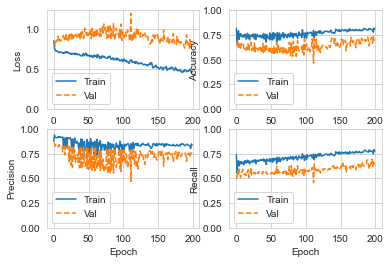

In [52]:
plot_metrics(history)

from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced' ,np.unique(y_train_labels) ,y_train_labels)
class_weight

Actual label:Positive
Predicted label: Positive
Actual label:Positive
Predicted label: Positive
Actual label:Neutral
Predicted label: Neutral
Actual label:Neutral
Predicted label: Positive
Actual label:Neutral
Predicted label: Neutral
Actual label:Neutral
Predicted label: Positive
Actual label:Neutral
Predicted label: Positive
Actual label:Neutral
Predicted label: Positive
Actual label:Neutral
Predicted label: Positive
Actual label:Positive
Predicted label: Neutral
Normalized confusion matrix


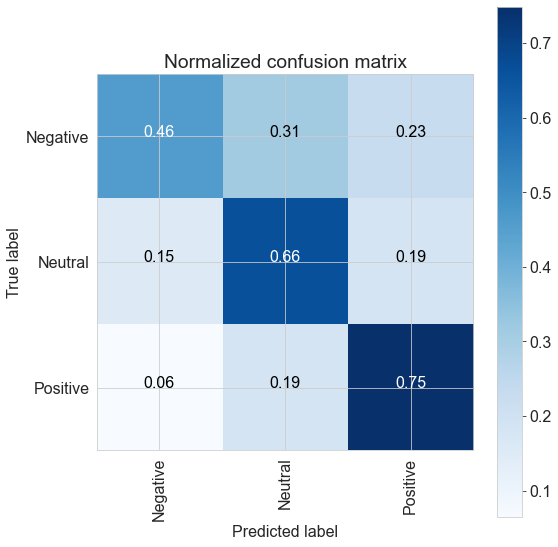

In [58]:
from sklearn.metrics import confusion_matrix
text_labels = encoder.classes_
label_names=['Negative','Neutral','Positive']

for i in range(10):
    prediction = model.predict(np.array([X_test[i]]))
    predicted_label = text_labels[np.argmax(prediction[0])]
    #print(test_files_names.iloc[i])
    print('Actual label:' + test_tags.iloc[i])
    print("Predicted label: " + predicted_label)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


y_pred = model.predict(X_test);
cnf_matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

# Plot normalized confusion matrix

fig = plt.figure()
fig.set_size_inches(8, 8, forward=True)
plt.rcParams.update({'font.size': 16})

#fig.align_labels()

# fig.subplots_adjust(left=0.0, right=1.0, bottom=0.0, top=1.0)
plot_confusion_matrix(cnf_matrix, classes=np.asarray(label_names), normalize=True,
                      title='Normalized confusion matrix')

fig.savefig("txt_classification-smote" + str(num_epochs) + ".png", pad_inches=5.0)

In [81]:
encoder.inverse_transform(y_test)

array(['Positive', 'Neutral', 'Neutral', ..., 'Neutral', 'Neutral',
       'Positive'], dtype='<U8')

***Deployment***

In [123]:
delilu= pd.read_excel(r'C:\Users\joel-\Documents\Tesis\commentsdelilu.xlsx')
delilu.head()

,id,parent_id,object_id,message,created_time,like_count,comment_count
0,253,4,5385637364812223_5389760717733221,NaN,2021-04-02 09:10:48,0.0,1.0
1,254,4,5385637364812223_5391297577579535,:D,2021-04-02 16:09:18,0.0,0.0
2,255,4,5385637364812223_5391709464205013,NaN,2021-04-02 18:27:53,1.0,1.0
3,256,4,5385637364812223_5400254766683816,🥰,2021-04-04 09:14:45,0.0,0.0
4,267,9,5260239854018642_5322553797787247,Daniela Gilces,2021-03-18 20:15:21,0.0,0.0


In [124]:
delilu.dropna(inplace=True)
delilu.head()

,id,parent_id,object_id,message,created_time,like_count,comment_count
1,254,4,5385637364812223_5391297577579535,:D,2021-04-02 16:09:18,0.0,0.0
3,256,4,5385637364812223_5400254766683816,🥰,2021-04-04 09:14:45,0.0,0.0
4,267,9,5260239854018642_5322553797787247,Daniela Gilces,2021-03-18 20:15:21,0.0,0.0
5,270,10,5260235984019029_5265073256868635,La que me gusta con delilu😈🥵😳,2021-03-05 22:58:38,0.0,1.0
6,271,10,5260235984019029_5275797155796245,Leí me vine en Lulú ._.,2021-03-08 11:55:28,0.0,1.0


In [125]:
delilu['message'] = delilu['message'].apply(lambda x: re.split('https:\/\/.*', str(x))[0]) #elimina url
delilu['message'] = delilu['message'].apply(lambda x: re.split('\d+', str(x))[0]) #elimina palabras con numeros


In [126]:
#elimina palabras con letras repetidas
def conti_rep_char(str1):
    tchr = str1.group(0)
    if len(tchr) > 1:
      return tchr[0:1]
      
def check_unique_char(rep, sent_text):
    
    convert = re.sub(r'(\w)\1+', rep,sent_text)
      
    #regresa la palabra convertida
    return convert
  
delilu['message'] = delilu['message'].apply(lambda x : check_unique_char(conti_rep_char,x))
delilu

,id,parent_id,object_id,message,created_time,like_count,comment_count
1,254,4,5385637364812223_5391297577579535,:D,2021-04-02 16:09:18,0.0,0.0
3,256,4,5385637364812223_5400254766683816,🥰,2021-04-04 09:14:45,0.0,0.0
4,267,9,5260239854018642_5322553797787247,Daniela Gilces,2021-03-18 20:15:21,0.0,0.0
5,270,10,5260235984019029_5265073256868635,La que me gusta con delilu😈🥵😳,2021-03-05 22:58:38,0.0,1.0
6,271,10,5260235984019029_5275797155796245,Leí me vine en Lulú ._.,2021-03-08 11:55:28,0.0,1.0
...,...,...,...,...,...,...,...
3896,4823,234,2130376903671635_2135123219863670,son ricas ya me compre un par,2018-06-30 23:33:16,0.0,0.0
3897,4834,239,2081255925250400_2108765545832771,note estoy en las nubes,2018-06-16 23:14:51,1.0,0.0
3898,4835,239,2081255925250400_2116303475078978,Wow👌,2018-06-20 23:58:45,0.0,0.0
3899,4840,241,2111276798914979_2121492991226693,que asco de momo,2018-06-23 15:14:10,0.0,0.0


In [127]:
delilu['message']
delilu['message'] = delilu['message'].apply(get_mentions_processing)
delilu['message']= delilu['message'].apply(get_hashtags_processing)
delilu['message'] = delilu['message'].apply(get_emojis_processing)
delilu['message'] = delilu['message'].apply(get_text_processing)
delilu['message']= delilu['message'].apply(get_less3words_processing)
delilu['message'] = delilu['message'].apply(normalize)
delilu[['message']]

,message
1,
3,carasonriendoconcorazones
4,daniela gilces
5,gusta delilu carasonriendoconcuernos caraconca...
6,lei vine lulu
...,...
3896,ricas compre par
3897,note nubes
3898,wow señaldeaprobacionconlamano
3899,asco momo


In [129]:
delilu['message'].replace('', np.nan, inplace=True) # Reemplazo los registros vacíos con NaN
print(delilu['message'].isna().sum()) 
delilu.dropna(axis=0, subset=['message'],inplace=True)
print(delilu.shape)
delilu

0
(2571, 7)


,id,parent_id,object_id,message,created_time,like_count,comment_count
3,256,4,5385637364812223_5400254766683816,carasonriendoconcorazones,2021-04-04 09:14:45,0.0,0.0
4,267,9,5260239854018642_5322553797787247,daniela gilces,2021-03-18 20:15:21,0.0,0.0
5,270,10,5260235984019029_5265073256868635,gusta delilu carasonriendoconcuernos caraconca...,2021-03-05 22:58:38,0.0,1.0
6,271,10,5260235984019029_5275797155796245,lei vine lulu,2021-03-08 11:55:28,0.0,1.0
7,272,10,5260235984019029_5275846755791285,nunca falte delilu,2021-03-08 12:09:19,0.0,0.0
...,...,...,...,...,...,...,...
3896,4823,234,2130376903671635_2135123219863670,ricas compre par,2018-06-30 23:33:16,0.0,0.0
3897,4834,239,2081255925250400_2108765545832771,note nubes,2018-06-16 23:14:51,1.0,0.0
3898,4835,239,2081255925250400_2116303475078978,wow señaldeaprobacionconlamano,2018-06-20 23:58:45,0.0,0.0
3899,4840,241,2111276798914979_2121492991226693,asco momo,2018-06-23 15:14:10,0.0,0.0


In [130]:
textos=delilu['message'].values
textos.shape


(2571,)

In [131]:
X_deploy = vect1.transform(textos)
X_deploy = tfidf.transform(X_deploy)
X_deploy = X_deploy.toarray()

In [132]:
preddelilu = model.predict(X_deploy)

In [133]:
preddelilu

array([[1.0215026e-05, 9.9987113e-01, 1.1864152e-04],
       [9.6325672e-01, 2.3513781e-02, 1.3229430e-02],
       [5.7554539e-09, 1.6162552e-02, 9.8383743e-01],
       ...,
       [1.9071965e-06, 9.8384780e-01, 1.6150311e-02],
       [9.8802060e-01, 1.1772936e-02, 2.0643907e-04],
       [1.3265784e-05, 9.9943501e-01, 5.5170699e-04]], dtype=float32)

In [134]:
sentimientos=encoder.inverse_transform(preddelilu)
sentimientos

array(['Neutral', 'Negative', 'Positive', ..., 'Neutral', 'Negative',
       'Neutral'], dtype='<U8')

In [135]:
label=pd.DataFrame(sentimientos, columns = ['label'])
label

,label
0,Neutral
1,Negative
2,Positive
3,Negative
4,Positive
...,...
2566,Positive
2567,Negative
2568,Neutral
2569,Negative


In [136]:
delilu['sentiment']=label['label']

AttributeError: 'AxesSubplot' object has no property 'fontsize'

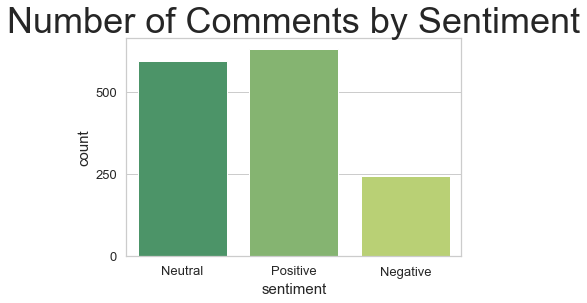

In [183]:
sns.set_style('whitegrid')
plt.xticks(size=13)
plt.yticks(size=13)
plt.xlabel("Sentiment",fontsize=15)
plt.ylabel("Number of Comments", fontsize=15)
a=sns.countplot(x='sentiment',data=delilu, palette='summer',order = favorita['sentiment'].value_counts().index).set(title="Number of Comments by Sentiment",fontsize=20)

La favorita

In [162]:
favorita= pd.read_excel(r'C:\Users\joel-\Documents\Tesis\commentsfavorita.xlsx')
favorita.head()

,id,parent_id,object_id,message,created_time
0,2411,48,3513707055341384_3550269558351800,#CocinandoConLaFavorita mi rico encebollado d...,2020-08-12 22:03:55
1,2412,48,3513707055341384_3550280388350717,#CocinandoConLaFavorita mis ricas empanadas d...,2020-08-12 22:08:54
2,2378,48,3513707055341384_3531473420231414,#CocinandoConLaFavorita Participando con un e...,2020-08-06 12:50:22
3,2380,48,3513707055341384_3531709220207834,#Cocinandoconlafavorita un delicioso moro mix...,2020-08-06 14:27:35
4,2537,60,3376308765747881_3381054451939979,#DiaDelPadre #PapaDeLasHamburguesas #Favorita...,2020-06-14 09:50:16


In [164]:
favorita.dropna(inplace=True)
favorita.head()

,id,parent_id,object_id,message,created_time
0,2411,48,3513707055341384_3550269558351800,#CocinandoConLaFavorita mi rico encebollado d...,2020-08-12 22:03:55
1,2412,48,3513707055341384_3550280388350717,#CocinandoConLaFavorita mis ricas empanadas d...,2020-08-12 22:08:54
2,2378,48,3513707055341384_3531473420231414,#CocinandoConLaFavorita Participando con un e...,2020-08-06 12:50:22
3,2380,48,3513707055341384_3531709220207834,#Cocinandoconlafavorita un delicioso moro mix...,2020-08-06 14:27:35
4,2537,60,3376308765747881_3381054451939979,#DiaDelPadre #PapaDeLasHamburguesas #Favorita...,2020-06-14 09:50:16


In [165]:
favorita['message'] = favorita['message'].apply(lambda x: re.split('https:\/\/.*', str(x))[0]) #elimina url
favorita['message'] = favorita['message'].apply(lambda x: re.split('\d+', str(x))[0]) #elimina palabras con numeros


In [166]:
#elimina palabras con letras repetidas
def conti_rep_char(str1):
    tchr = str1.group(0)
    if len(tchr) > 1:
      return tchr[0:1]
      
def check_unique_char(rep, sent_text):
    
    convert = re.sub(r'(\w)\1+', rep,sent_text)
      
    #regresa la palabra convertida
    return convert
  
favorita['message'] = favorita['message'].apply(lambda x : check_unique_char(conti_rep_char,x))
favorita

,id,parent_id,object_id,message,created_time
0,2411,48,3513707055341384_3550269558351800,#CocinandoConLaFavorita mi rico encebolado de...,2020-08-12 22:03:55
1,2412,48,3513707055341384_3550280388350717,#CocinandoConLaFavorita mis ricas empanadas d...,2020-08-12 22:08:54
2,2378,48,3513707055341384_3531473420231414,#CocinandoConLaFavorita Participando con un e...,2020-08-06 12:50:22
3,2380,48,3513707055341384_3531709220207834,#Cocinandoconlafavorita un delicioso moro mix...,2020-08-06 14:27:35
4,2537,60,3376308765747881_3381054451939979,#DiaDelPadre #PapaDeLasHamburguesas #Favorita...,2020-06-14 09:50:16
...,...,...,...,...,...
8975,1689,11,4007174879327930_4026103700768381,🥰,2021-01-25 10:05:50
8976,1912,23,3905710489474370_3950134178365334,🥰,2020-12-27 19:15:27
8977,3733,92,3176765452368881_3196035400441886,🥰,2020-04-02 09:51:01
8978,2119,29,3842378939140859_3842925522419534,🥳,2020-11-17 17:08:28


In [167]:
favorita['message']
favorita['message'] = favorita['message'].apply(get_mentions_processing)
favorita['message']= favorita['message'].apply(get_hashtags_processing)
favorita['message'] = favorita['message'].apply(get_emojis_processing)
favorita['message'] = favorita['message'].apply(get_text_processing)
favorita['message']= favorita['message'].apply(get_less3words_processing)
favorita['message'] = favorita['message'].apply(normalize)
favorita[['message']]

,message
0,rico encebolado albacora preparado aceite favo...
1,ricas empanadas polo carne venta emprendimient...
2,participando exquisito yapingacho preparado am...
3,delicioso moro mixto polo chancho chuzo cuenca...
4,hamburguesa hamburguesa hamburguesa kleber ale...
...,...
8975,carasonriendoconcorazones
8976,carasonriendoconcorazones
8977,carasonriendoconcorazones
8978,caradefiesta


In [168]:
favorita['message'].replace('', np.nan, inplace=True) # Reemplazo los registros vacíos con NaN
print(favorita['message'].isna().sum()) 
favorita.dropna(axis=0, subset=['message'],inplace=True)
print(favorita.shape)
favorita

309
(8671, 5)


,id,parent_id,object_id,message,created_time
0,2411,48,3513707055341384_3550269558351800,rico encebolado albacora preparado aceite favo...,2020-08-12 22:03:55
1,2412,48,3513707055341384_3550280388350717,ricas empanadas polo carne venta emprendimient...,2020-08-12 22:08:54
2,2378,48,3513707055341384_3531473420231414,participando exquisito yapingacho preparado am...,2020-08-06 12:50:22
3,2380,48,3513707055341384_3531709220207834,delicioso moro mixto polo chancho chuzo cuenca...,2020-08-06 14:27:35
4,2537,60,3376308765747881_3381054451939979,hamburguesa hamburguesa hamburguesa kleber ale...,2020-06-14 09:50:16
...,...,...,...,...,...
8975,1689,11,4007174879327930_4026103700768381,carasonriendoconcorazones,2021-01-25 10:05:50
8976,1912,23,3905710489474370_3950134178365334,carasonriendoconcorazones,2020-12-27 19:15:27
8977,3733,92,3176765452368881_3196035400441886,carasonriendoconcorazones,2020-04-02 09:51:01
8978,2119,29,3842378939140859_3842925522419534,caradefiesta,2020-11-17 17:08:28


In [169]:
textos=favorita['message'].values
textos.shape

(8671,)

In [170]:
X_deploy = vect1.transform(textos)
X_deploy = tfidf.transform(X_deploy)
X_deploy = X_deploy.toarray()

In [174]:
predfav = model.predict(X_deploy)

In [175]:
sentimientos=encoder.inverse_transform(predfav)
sentimientos

array(['Positive', 'Positive', 'Positive', ..., 'Neutral', 'Positive',
       'Positive'], dtype='<U8')

In [176]:
label=pd.DataFrame(sentimientos, columns = ['label'])
label

,label
0,Positive
1,Positive
2,Positive
3,Positive
4,Neutral
...,...
8666,Neutral
8667,Neutral
8668,Neutral
8669,Positive


In [177]:
favorita['sentiment']=label['label']

[Text(0.5, 1.0, 'Number of Comments by Sentiment')]

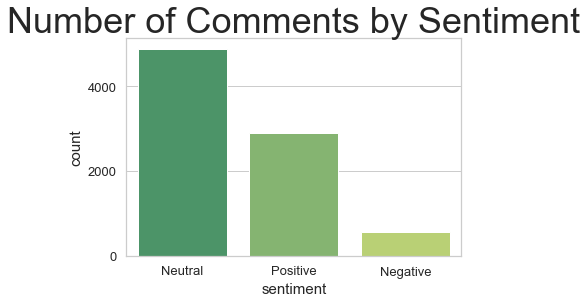

In [182]:
sns.set_style('whitegrid')
plt.xticks(size=13)
plt.yticks(size=13)
plt.xlabel("Sentiment",fontsize=15)
plt.ylabel("Number of Comments", fontsize=15)
sns.countplot(x='sentiment',data=favorita, palette='summer',order = favorita['sentiment'].value_counts().index).set(title="Number of Comments by Sentiment")